In [ ]:
import sys
import os

project_root = '' # Give path of your root directory
sys.path.append(project_root)

In [ ]:
from src.preprocessing import preprocess_data
processed_df = preprocess_data(raw_df.copy()) 

In [ ]:
# After adding cluster labels
from src.data_loader import save_processed_data
save_processed_data(processed_df, r'data\processed\processed_data.csv') # save it.

In [ ]:
processed_df.head()

,Borrower_ID,Age,Gender,Monthly_Income,Num_Dependents,Loan_ID,Loan_Amount,Loan_Tenure,Interest_Rate,Loan_Type,...,Collection_Attempts,Legal_Action_Taken,Employment_Type_Salaried,Employment_Type_Self-Employed,Collection_Method_Debt Collectors,Collection_Method_Legal Notice,Collection_Method_Settlement Offer,Loan_to_income_ratio,EMI_to_income_ratio,Has_Collateral
0,BRW_1,59,0,215422,0,LN_1,1445796,60,12.39,0,...,1,0,True,False,False,False,True,6.711459,0.022546,1
1,BRW_2,49,1,60893,0,LN_2,1044620,12,13.47,1,...,2,0,True,False,False,False,True,17.155010,0.910346,1
2,BRW_3,35,0,116520,1,LN_3,1923410,72,7.74,0,...,2,0,True,False,False,True,False,16.507123,0.122937,1
3,BRW_4,63,1,140818,2,LN_4,1811663,36,12.23,0,...,2,0,True,False,False,False,False,12.865280,0.044378,1
4,BRW_5,28,0,76272,1,LN_5,88578,48,16.13,2,...,0,0,True,False,True,False,False,1.161344,0.010705,0


In [ ]:
import pandas as pd
from src.data_loader import load_data, save_processed_data 
from src.preprocessing import save_scaler, save_kmeans_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns 

In [ ]:
df = load_data(r'data\processed\processed_data.csv') # Load the preprocessed data.
print("DataFrame loaded. Head:")
print(df.head())
print("\nColumns after load:", df.columns.tolist())

DataFrame loaded. Head:
  Borrower_ID  Age  Gender  Monthly_Income  Num_Dependents Loan_ID  \
0       BRW_1   59       0          215422               0    LN_1   
1       BRW_2   49       1           60893               0    LN_2   
2       BRW_3   35       0          116520               1    LN_3   
3       BRW_4   63       1          140818               2    LN_4   
4       BRW_5   28       0           76272               1    LN_5   

   Loan_Amount  Loan_Tenure  Interest_Rate  Loan_Type  ...  \
0      1445796           60          12.39          0  ...   
1      1044620           12          13.47          1  ...   
2      1923410           72           7.74          0  ...   
3      1811663           36          12.23          0  ...   
4        88578           48          16.13          2  ...   

   Collection_Attempts  Legal_Action_Taken  Employment_Type_Salaried  \
0                    1                   0                      True   
1                    2                

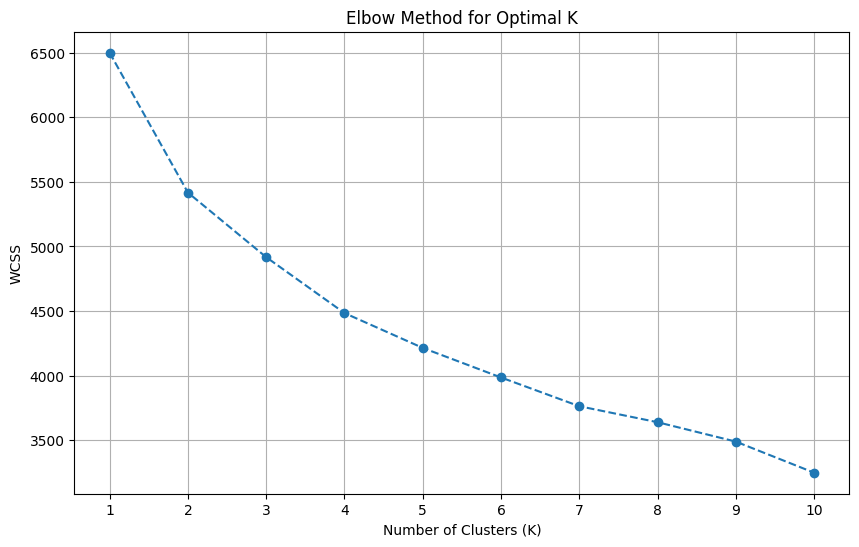

In [5]:
kmeans_features = [
    'Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
    'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI',
    'Num_Missed_Payments', 'Days_Past_Due',
    'Loan_to_income_ratio',  
    'EMI_to_income_ratio',   
    'Has_Collateral'
]

for feature in kmeans_features:
    if feature not in df.columns:
        print(f"Warning '{feature} not found in DataFrame for K-Means. Check your preprocessing")

scaler = StandardScaler()
df_scaled_kmeans = scaler.fit_transform(df[kmeans_features])

wcss = []
for i in range(1,11):
    kmeans_temp = KMeans(n_clusters=i,init='k-means++',random_state=42, n_init=10)
    kmeans_temp.fit(df_scaled_kmeans)
    wcss.append(kmeans_temp.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k,random_state=42,n_init=10)

df['Borrower_Segment'] = kmeans.fit_predict(df_scaled_kmeans)

fig = px.scatter(df, x='Monthly_Income', y='Loan_Amount',
                 color=df['Borrower_Segment'].astype(str), size='Loan_Amount', 
                 hover_data={'Monthly_Income': True, 'Loan_Amount': True, 'Borrower_Segment': True, 'Recovery_Status': True}, 
                 title="Borrower Segments Based on Monthly Income and Loan Amount",
                 labels={"Monthly_Income": "Monthly Income ($)", "Loan_Amount": "Loan Amount ($)", "Borrower_Segment": "Segment"},
                 color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_layout(
    xaxis_title="Monthly Income ($)",
    yaxis_title="Loan Amount ($)",
    template="plotly_white",
    legend_title="Borrower Segment"
)

fig.show()

In [ ]:
print("\nSegment Profiles:")
segment_profiles = df.groupby('Borrower_Segment').agg({
    'Monthly_Income': ['mean', 'median', 'min', 'max'],
    'Loan_Amount': ['mean', 'median', 'min', 'max'],
    'Age': 'mean',
    'Interest_Rate': 'mean',
    'Num_Missed_Payments': 'mean',
    'EMI_to_income_ratio': 'mean', 
    'Loan_to_income_ratio': 'mean', 
    'Recovery_Status': lambda x: x.value_counts(normalize=True).to_dict() 
}).round(2)
print(segment_profiles)


Segment Profiles:
                 Monthly_Income                          Loan_Amount  \
                           mean    median    min     max        mean   
Borrower_Segment                                                       
0                      62132.97   46348.0  15207  224988  1554375.48   
1                     140380.24  145466.5  15281  249386   458425.45   
2                     132331.61  126453.0  21471  246804  1343514.90   
3                     145039.87  139731.5  18726  249746  1519399.46   

                                                Age Interest_Rate  \
                     median     min      max   mean          mean   
Borrower_Segment                                                    
0                 1651948.0  426047  1995049  45.48          9.38   
1                  416329.0   54138  1392501  43.17         11.87   
2                 1429932.0  510115  1977716  42.84         10.22   
3                 1501115.0  742924  1995325  42.73         11

In [8]:
df['Segment_Name'] = df['Borrower_Segment'].map({
    0: 'Stable Income, Manageable Loan, Low Risk',
    1: 'High Loan Burden, Critical Risk',
    2: 'High Missed Payments, Behavioral Risk',
    3: 'High Income, Large Loan, Managed Risk'
})

In [ ]:
df['High_Risk_Flag'] = df['Segment_Name'].apply(lambda x: 1 if x in ['High Loan Burden, Critical Risk', 'High Missed Payments, Behavioral Risk'] else 0)

print("\nDataFrame with Segments and High Risk Flag (Revised):")
print(df[['Borrower_ID', 'Monthly_Income', 'Loan_Amount', 'Borrower_Segment', 'Segment_Name', 'High_Risk_Flag', 'Recovery_Status', 'EMI_to_income_ratio', 'Num_Missed_Payments']].head())


save_processed_data(df, r'C:\Loan Recovery ML Project\data\processed\segmented_and_flagged_data.csv') #Now save this as a new csv file.
print("\nSegmented and flagged data saved to C:\Loan Recovery ML Project\data\processed\segmented_and_flagged_data.csv")


DataFrame with Segments and High Risk Flag (Revised):
  Borrower_ID  Monthly_Income  Loan_Amount  Borrower_Segment  \
0       BRW_1          215422      1445796                 3   
1       BRW_2           60893      1044620                 0   
2       BRW_3          116520      1923410                 3   
3       BRW_4          140818      1811663                 3   
4       BRW_5           76272        88578                 1   

                               Segment_Name  High_Risk_Flag  Recovery_Status  \
0     High Income, Large Loan, Managed Risk               0                1   
1  Stable Income, Manageable Loan, Low Risk               0                0   
2     High Income, Large Loan, Managed Risk               0                0   
3     High Income, Large Loan, Managed Risk               0                0   
4           High Loan Burden, Critical Risk               1                0   

   EMI_to_income_ratio  Num_Missed_Payments  
0             0.022546           